# Many-Body Tensor Approximation with MNIST

In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from PIL import Image

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import ld

In [2]:
def renormalize_image(image, threshold=False, threshold_value=10):
    """
    Renormalize an image such that pixel values are between 0 and 255.
    Optionally, set small pixel values to 0.

    Parameters:
    - image: numpy array with shape (28, 28)
    - threshold: bool, if True, set small pixel values to 0
    - threshold_value: int, the value below which pixels are set to 0 (if threshold is True)

    Returns:
    - renormalized_image: numpy array with shape (28, 28), pixel values between 0 and 255
    """
    # Ensure the image is a numpy array
    image = np.array(image)

    # Renormalize pixel values to be between 0 and 255
    min_val = np.min(image)
    max_val = np.max(image)
    renormalized_image = 255 * (image - min_val) / (max_val - min_val)

    # Apply threshold if needed
    if threshold:
        renormalized_image[renormalized_image < threshold_value] = 0

    return renormalized_image.astype(np.uint8)

def vectorize_tensor(T, B):
    """
    Vectorizes the tensor T by selecting only the indices in B.

    Parameters:
    - T: numpy array of shape (num_samples, ...)
    - B: list of indices to select from each sample

    Returns:
    - V: vectorized representation of T of shape (num_samples, len(B))
    """
    num_samples = T.shape[0]
    V = np.zeros((num_samples, len(B)))
    for i in range(num_samples):
        for j, idx in enumerate(B):
            V[i, j] = T[i, *idx]
    return V

def reconstruct_tensor(V, T_shape, B):
    """
    Reconstructs the tensor T from its vectorized representation V.

    Parameters:
    - V: vectorized representation of T of shape (num_samples, len(B))
    - T_shape: original shape of the tensor T
    - B: list of indices that were used to create the vectorized representation

    Returns:
    - T: reconstructed tensor with the original shape, missing values filled with zero
    """
    num_samples = V.shape[0]
    T = np.zeros(T_shape)
    for i in range(num_samples):
        for j, idx in enumerate(B):
            T[i, *idx] = V[i, j]
    return T

## Basic Many-Body Tensor Approximation

### Dataset

In [3]:
D = 28*28
S = (7, 2, 2, 7, 2, 2)

In [4]:
save_dir = './data/MNIST_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    # Download MNIST dataset
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root='./data', download=True, train=True, transform=transform)

    # Save images by class
    for class_label in range(10):
        class_dir = os.path.join(save_dir, str(class_label))
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        indices = np.where(train_dataset.targets.numpy() == class_label)[0]
        for i, idx in enumerate(indices):
            img, _ = train_dataset[idx]
            img = transforms.ToPILImage()(img)
            img.save(os.path.join(class_dir, f'{i}.png'))

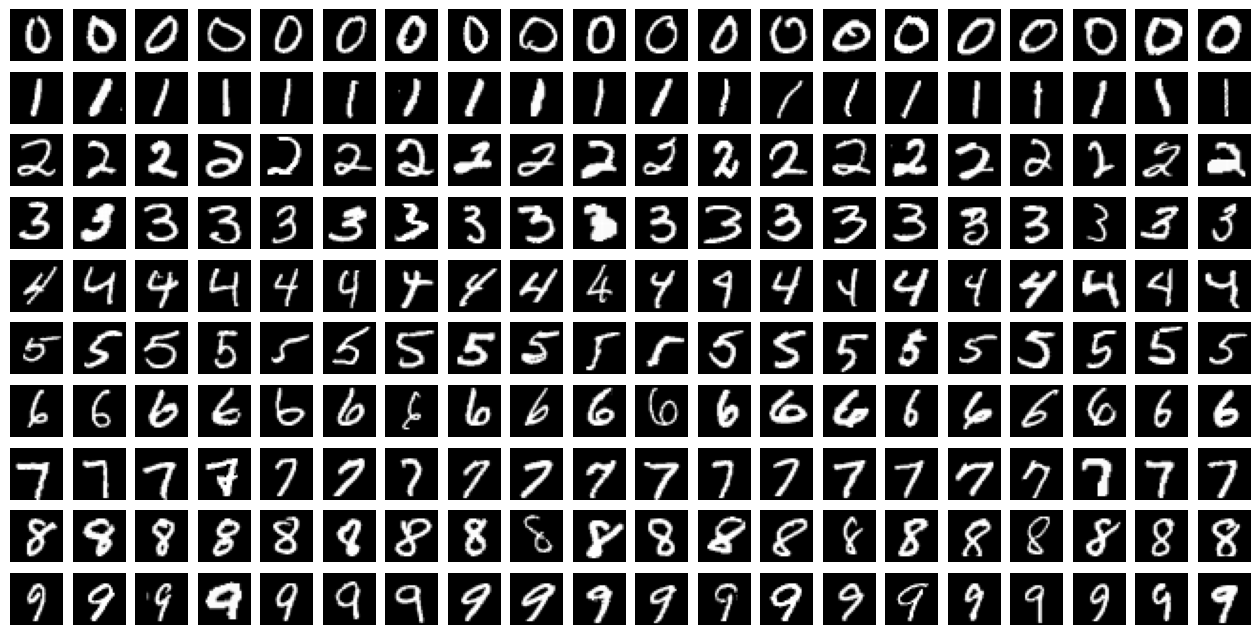

In [5]:
# Function to load images from a directory
def load_images_from_folder(folder, max_images=20):
    images = []
    for filename in os.listdir(folder)[:max_images]:
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

# Load and display images horizontally for each class
plt.figure(figsize=(16, 8))  # Adjust the figure size as needed
for class_label in range(10):
    class_folder = os.path.join(save_dir, str(class_label))
    images = load_images_from_folder(class_folder)
    for i, img in enumerate(images):
        plt.subplot(10, 20, class_label * 20 + i + 1)
        # img = img.resize(S)
        img = img.resize((28, 28))
        plt.imshow(img, cmap='gray')
        plt.axis('off')  # Hide axes

plt.show()

### Specific Digit

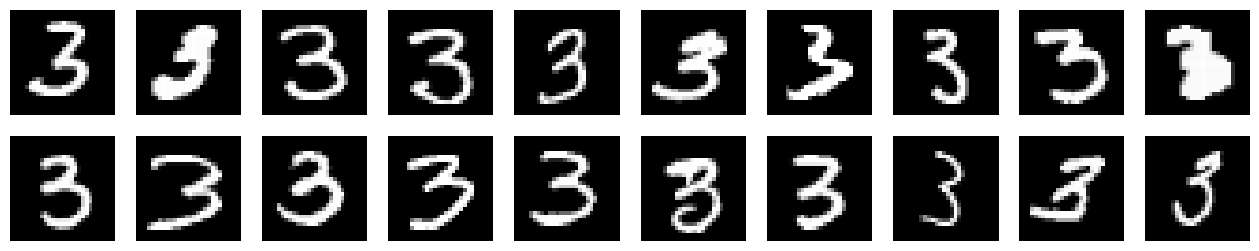

In [6]:
P = []
train_size = 1000
class_label = 3  # 0-9

class_folder = os.path.join(save_dir, str(class_label))
images = load_images_from_folder(class_folder, max_images=train_size)

for k in range(1, len(images) + 1):
    img = images[k - 1]
    # img = img.resize(S)
    img = img.resize((28, 28))
    array_obj = np.asarray(img).reshape(S)
    P.append(array_obj)

P = np.array(P)

plt.figure(figsize=(16, 3))
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(P[i].reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
    plt.axis('off')  # Hide axes

plt.show()

## Data Generation

### Legendre Decomposition

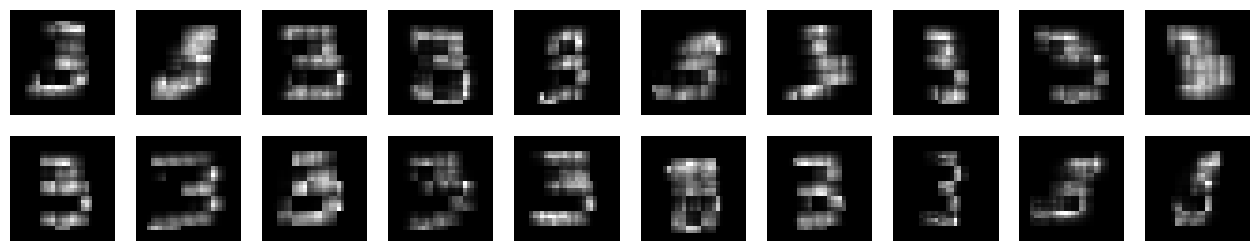

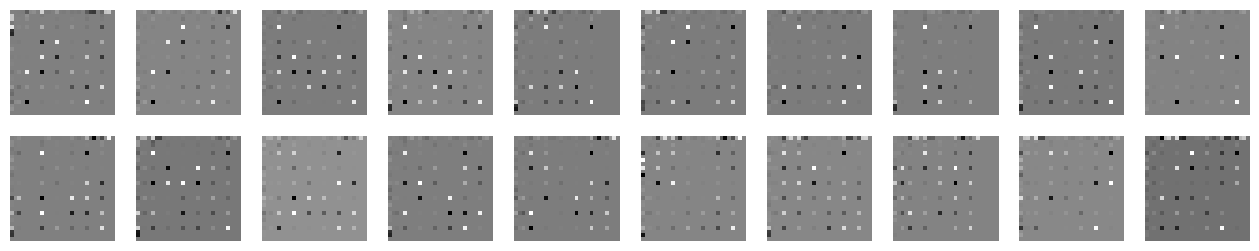

In [7]:
scaleX = []
Q = []
theta = []
X_recons = []

B_LD = ld.default_B(S, 2, cp.get_array_module(P[0]))

for i in range(train_size):
    history_kl, history_norm, scaleX_, Q_, theta_ = ld.LD(P[i], B=B_LD, verbose=False, n_iter=1000, lr=1e-1)
    scaleX.append(scaleX_)
    Q.append(Q_)
    theta.append(theta_)
    X_recons_ = (Q_ * scaleX_).astype(np.int32)
    X_recons.append(X_recons_)

scaleX = np.array(scaleX)
theta = np.array(theta)

plt.figure(figsize=(16, 3))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(renormalize_image(X_recons[i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
    plt.axis('off')

plt.show()

plt.figure(figsize=(16, 3))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(theta[i].reshape((28, 28)), cmap='gray')
    plt.axis('off')

plt.show()

### Fitting and Sampling

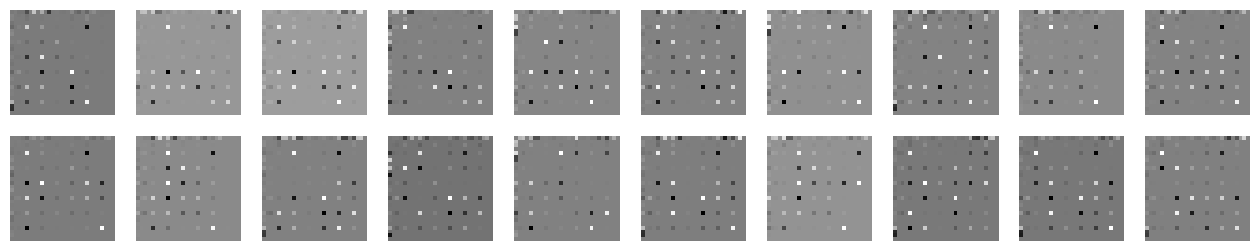

In [8]:
from sklearn.neighbors import KernelDensity

num_new_samples = 20

reduced_theta = vectorize_tensor(theta, B_LD)

# Fit a KDE to the theta values
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(reduced_theta)
# Sample new data from the KDE
sampled_reduced_theta = kde.sample(n_samples=num_new_samples)

sampled_theta = reconstruct_tensor(sampled_reduced_theta, (num_new_samples, *S), B_LD)

plt.figure(figsize=(16, 3))
for i in range(sampled_theta.shape[0]):
    plt.subplot(2, 10, i + 1)
    plt.imshow(sampled_theta[i].reshape((28, 28)), cmap='gray')
    plt.axis('off')
plt.show()

### Construct Submanifold

In [9]:
# Construct the constrained coordinates
# B_BP = ld.block_B([14, 14], [15, 15])
B_BP = ld.default_B(S, 1, cp.get_array_module(P[0]))

# Compute every datapoint's eta_hat (served as the linear constraints)
eta_hat = []

for i in range(P.shape[0]):
    eps = np.asarray(1.0e-5)
    xp = cp.get_array_module(P[i])
    P_ = (P[i] + eps) / scaleX[i]
    eta_hat_ = ld.get_eta(P_, len(S), xp)
    eta_hat.append(eta_hat_)

eta_hat = cp.asarray(eta_hat)

### Backward Projection

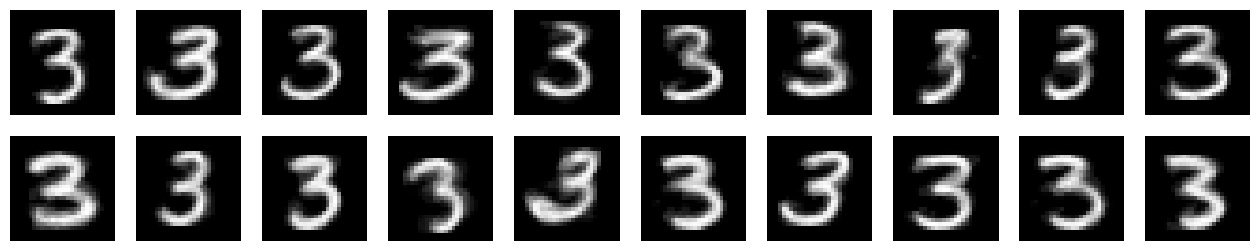

In [13]:
sampled_P_BP = []
sampled_theta_BP = []
sampled_X_recons = []

for i in range(num_new_samples):
    ks = ld.kNN(sampled_theta[i], theta, k=8)

    avg_scale = np.mean(scaleX[ks])
    avg_eta_hat = np.mean(eta_hat[ks], axis=0)

    history_kl, history_norm, P_, theta_ = ld.BP(sampled_theta[i], [(P[k] + eps) / scaleX[k] for k in ks], avg_eta_hat, avg_scale, B=B_BP, verbose=False, n_iter=1000, lr=1e-1)
    sampled_P_BP.append(P_)
    sampled_theta_BP.append(theta_)

    X_recons_ = (P_).astype(np.int32)
    sampled_X_recons.append(X_recons_)

sampled_P_BP = np.array(sampled_P_BP)
sampled_theta_BP = np.array(sampled_theta_BP)
sampled_X_recons = np.array(sampled_X_recons)

plt.figure(figsize=(16, 3))
for i in range(sampled_theta.shape[0]):
    plt.subplot(2, 10, i + 1)
    plt.imshow(renormalize_image(sampled_X_recons[i]).reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
    plt.axis('off')
plt.show()

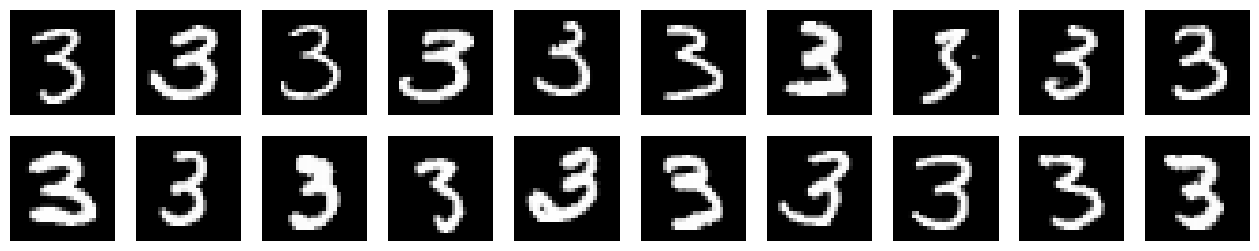

In [14]:
# Find the nearest distance between every new sample among the training set in terms of norm.

plt.figure(figsize=(16, 3))

for i in range(num_new_samples):
    norm = [np.linalg.norm(sampled_X_recons[i].reshape((28, 28)) - p.reshape((28, 28))) for p in P]
    idx = np.argmin(norm)
    # print(f"Nearest distance: new sample {i} and training sample {idx}: {norm[idx]}")

    plt.subplot(2, 10, i+1)
    plt.imshow(P[idx].reshape((28, 28)), cmap='gray', vmin=0, vmax=255) # [0, 255]
    plt.axis('off')  # Hide axes

plt.show()